In [30]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [120]:

def scaler(X_train, X_test, minmax = False):
    '''
    Arguments: X_train and X_test data
    Optional: minmax (scale between 0 and 1)

    Returns: X_train and X_test either standardized by demeaning, or scaled to 1
    '''
    if minmax == True:
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# def get_indices(df):
#     X_full_indices = df.drop(['pt_suc', 'pt_attempt'], axis =1 ).columns
#     return X_full_indices


def splitter(df, target = 'pt_attempt', test_size = .25, random_state = 29, VIF_drop = False, scaled = False, minmax = False):
    '''
    Arguments: The dataframe
    Optional Args: test size, random state, whether to drop a list (determined by VIF correlations)
    whether to scale, whether to use minmax scaling (between 0 and 1)

    Returns:
    X_train, X_test, y_train, y_test, and the feature labels for the columns in X
    '''
    
    _targets = ['pt_attempt', 'pt_suc']
    if VIF_drop == True:
        df = df.drop(vifdrops, axis = 1)
        y = df[target]
        X = df.drop(_targets, axis = 1)
    if VIF_drop == False:
        y = df[target]
        X = df.drop(_targets, axis = 1)
    colnames = X.columns
    idx = colnames.to_numpy()
    feature_labels = np.concatenate((['constant'], idx) )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state= random_state, stratify = y )
    if scaled == True:
        X_train, X_test = scaler(X_train, X_test, minmax = minmax)
    X_train = add_constant(X_train)    
    X_test =  add_constant(X_test)    
    return X_train, X_test, y_train, y_test, feature_labels

def upsampler(X_train, y_train, target = 'pt_attempt'):
    '''
    Args: X_train and y_train
    Optional: what is the target
    Returns: y_train, and X_train with the target rows sampled with replacement to equal 
    the number of non-target rows (makes X_train much bigger)
    '''
    y_train = pd.Series(y_train)
    
    X = pd.concat([X_train, y_train], axis=1) 
    no_coup = X[X[target]==0]
    coup = X[X[target]==1]
    coups_upsampled = resample(coup,
                          replace=True, # sample with replacement
                          n_samples=len(no_coup), # match number in majority class
                          random_state=29)
    upsampled = pd.concat([no_coup, coups_upsampled])
    y_up = upsampled[target]
    X_up = upsampled.drop(target, axis = 1)
    return X_up, y_up

def downsampler(X_train, y_train, target = 'pt_attempt'):
    '''
    Args: X_train and y_train
    Optional: what is the target
    Returns: y_train, and X_train with the non-target rows sampled with replacement to equal 
    the number of target rows (makes X_train much smaller)

    '''
    X = pd.concat([X_train, y_train], axis=1) 
    no_coup = X[X[target]==0]
    coup = X[X[target]==1]
    coups_downsampled = resample(no_coup,
                          replace=True, # sample with replacement
                          n_samples=len(coup), # match number in majority class
                          random_state=29)
    downsampled = pd.concat([coup, coups_downsampled])
    y_down = downsampled[target]
    X_down = downsampled.drop(target, axis = 1)
    return X_down, y_down

def smoter(X_train, y_train, ratio = 1.0):
    '''
    Args: X_train and y_train
    Optional: ratio
    Returns: y_train, and X_train with new target rows synthetically added to equal 
    the number of target rows (makes X_train much smaller) (or a different)
    '''
    sm = SMOTE(random_state=29, ratio=ratio)
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
    return X_train_sm, y_train_sm



def data_pipeline(df, target = 'pt_attempt', test_size = .25, random_state = 29, VIF_drop = False, scaled = False, minmax = False, resampler = None, sample_ratio = 1):
    '''
    Processes the onehot encoded dataframe to prepare it for modelling, with optional arguments 
    to drop collinear columns, resample, and scale.

    Args: dataframe, 
    optional: target columns, ratio for test train split, random state,
    whether to drop the vif_list, whether to scale, whether to use minmax (only makes sense if scaled = True),
    whether to resample, and what ratio to resample at (only currenly implemented with SMOTE)
    R

    '''
    X_train, X_test, y_train, y_test, feature_labels = splitter(df, target = 'pt_attempt', test_size = .25, 
                                                random_state = 29, VIF_drop = VIF_drop, scaled = scaled, minmax = minmax)
    if resampler == 'upsample':
        X_train, y_train = upsampler(X_train, y_train)
    if resampler == 'downsample':
        X_train, y_train = downsampler(X_train, y_train)
    if resampler == 'smote':
        X_train, y_train = smoter(X_train, y_train, ratio = sample_ratio)
    return X_train, X_test, y_train, y_test, feature_labels

def get_feature_weights(model, feature_labels):
    '''
    returns coefficients for features in a model (intended for logistic regression) 
    args: model, feature_labels
    returns: a sorted series in ascending order of feature weights.
    '''
    d_log_vals = {}
    for idx, feat in enumerate(model.coef_[0]):
        d_log_vals[feature_labels[idx]] = feat  
    s_log_vals = (pd.Series(d_log_vals)).sort_values()
    return s_log_vals

def metric_test(model, X_test, y_test):
    '''
    Prints out the accuracy, recall, precision, and f1 score for the 
    fit model when it predicts on the test data
    '''
    preds = model.predict(X_test)
    print('accuracy = ' + str(accuracy_score(y_test, preds)))
    print('recall = ' + str(recall_score(y_test, preds)))
    print('precision = ' + str(precision_score(y_test, preds)))
    print('f1 score = ' + str(f1_score(y_test, preds)))
    #print('r2_score = ' + str(r2_score(y_test, preds)))


def fit_test_model(model, X_train, X_test, y_train, y_test, indices, do_metric_test = True, get_features = False):
    '''
    fits a model to the training data, with the option argument to print out the feature weights
    '''
    model.fit(X_train, y_train)
    if do_metric_test == True:
        metric_test(model, X_test, y_test)
    if get_features == True:
        features = get_feature_weights(model, indices)
        print(features)
    return model

def variance_inflation_factors(X):
    '''
    calculates VIF values for the X dataset, inteded to be used iteratively to reduce 
    collinearity by dropping values from X and rechecking the values
    '''
    # X = add_constant(X)
    vifs = pd.Series(
        [1 / (1. - OLS(X[col].values, 
                       X.loc[:, X.columns != col].values).fit().rsquared) 
         for col in X],
        index=X.columns,
        name='VIF'
    )
    return vifs.sort_values()

In [80]:
df = pd.read_pickle('../data/pickles/reign_wb_model_ready.pkl')

In [81]:
df = pd.read_pickle('../data/pickles/joint_df.pkl')

In [83]:
df

ccode country                        leader    year  month  elected  \
11       2.0     USA                    Eisenhower  1960.0    1.0      1.0   
12       2.0     USA                    Eisenhower  1961.0    1.0      1.0   
13       2.0     USA                       Kennedy  1961.0    1.0      1.0   
14       2.0     USA                       Kennedy  1962.0    1.0      1.0   
15       2.0     USA                       Kennedy  1963.0    1.0      1.0   
...      ...     ...                           ...     ...    ...      ...   
11363  990.0   Samoa  Tuilaepa Sailele Malielegaoi  2015.0    1.0      1.0   
11364  990.0   Samoa  Tuilaepa Sailele Malielegaoi  2016.0    1.0      1.0   
11365  990.0   Samoa  Tuilaepa Sailele Malielegaoi  2017.0    1.0      1.0   
11366  990.0   Samoa  Tuilaepa Sailele Malielegaoi  2018.0    1.0      1.0   
11367  990.0   Samoa  Tuilaepa Sailele Malielegaoi  2019.0    1.0      1.0   

        age  male  militarycareer  tenure_months               government  \
11     70.0     1             1.0           85.0   Presidential Democracy   
12     71.0     1             1.0           97.0   Presidential Democracy   
13     44.0     1             0.0            1.0   Presidential Democracy   
14     45.0     1             0.0           13.0   Presidential Democracy   
15     46.0     1             0.0           25.0   Presidential Democracy   
...     ...   ...             ...            ...                      ...   
11363  70.0     1             0.0          194.0  Parliamentary Democracy   
11364  71.0     1             0.0          206.0  Parliamentary Democracy   
11365  72.0     1             0.0          218.0  Parliamentary Democracy   
11366  73.0     1             0.0          230.0  Parliamentary Democracy   
11367  74.0     1             0.0          242.0  Parliamentary Democracy   

       anticipation  ref_ant  leg_ant  exec_ant  irreg_lead_ant  election_now  \
11              0.0      0.0      0.0       0.0             0.0           0.0   
12              0.0      0.0      0.0       0.0             0.0           0.0   
13              0.0      0.0      0.0       0.0             0.0           0.0   
14              0.0      0.0      0.0       0.0             0.0           0.0   
15              0.0      0.0      0.0       0.0             0.0           0.0   
...             ...      ...      ...       ...             ...           ...   
11363           0.0      0.0      0.0       0.0             0.0           0.0   
11364           1.0      0.0      1.0       0.0             0.0           0.0   
11365           0.0      0.0      0.0       0.0             0.0           0.0   
11366           0.0      0.0      0.0       0.0             0.0           0.0   
11367           0.0      0.0      0.0       0.0             0.0           0.0   

       election_recent  leg_recent  exec_recent  lead_recent  ref_recent  \
11                 0.0         0.0          0.0          0.0         0.0   
12                 1.0         0.0          1.0          1.0         0.0   
13                 1.0         0.0          1.0          1.0         0.0   
14                 0.0         0.0          0.0          0.0         0.0   
15                 0.0         0.0          0.0          0.0         0.0   
...                ...         ...          ...          ...         ...   
11363              0.0         0.0          0.0          0.0         0.0   
11364              0.0         0.0          0.0          0.0         0.0   
11365              0.0         0.0          0.0          0.0         0.0   
11366              0.0         0.0          0.0          0.0         0.0   
11367              0.0         0.0          0.0          0.0         0.0   

       direct_recent  indirect_recent  victory_recent  defeat_recent  \
11               0.0              0.0             0.0            0.0   
12               1.0              0.0             0.0            1.0   
13               1.0              0.0      

In [33]:
df_ready = df.dropna().drop('Land area (sq. km)', axis = 1)

In [41]:
df_ready.describe()

year   month      elected          age         male  \
count  9953.000000  9953.0  9953.000000  9953.000000  9953.000000   
mean   1992.114739     1.0     0.661107    57.686326     0.970461   
std      16.752804     0.0     0.473357    11.160022     0.169320   
min    1960.000000     1.0     0.000000    18.000000     0.000000   
25%    1978.000000     1.0     0.000000    50.000000     1.000000   
50%    1993.000000     1.0     1.000000    57.000000     1.000000   
75%    2007.000000     1.0     1.000000    65.000000     1.000000   
max    2019.000000     1.0     1.000000    94.000000     1.000000   

       militarycareer  tenure_months  anticipation      ref_ant      leg_ant  \
count     9953.000000    9953.000000   9953.000000  9953.000000  9953.000000   
mean         0.195921      85.217321      0.101276     0.009645     0.036974   
std          0.396928      98.557147      0.301709     0.097741     0.188707   
min          0.000000       1.000000      0.000000     0.000000     0.000000   
25%          0.000000      19.000000      0.000000     0.000000     0.000000   
50%          0.000000      49.000000      0.000000     0.000000     0.000000   
75%          0.000000     113.000000      0.000000     0.000000     0.000000   
max          1.000000     669.000000      1.000000     1.000000     1.000000   

          exec_ant  irreg_lead_ant  election_now  election_recent  \
count  9953.000000     9953.000000   9953.000000      9953.000000   
mean      0.055159        0.017181      0.012459         0.110821   
std       0.228302        0.129951      0.110926         0.313926   
min       0.000000        0.000000      0.000000         0.000000   
25%       0.000000        0.000000      0.000000         0.000000   
50%       0.000000        0.000000      0.000000         0.000000   
75%       0.000000        0.000000      0.000000         0.000000   
max       1.000000        1.000000      1.000000         1.000000   

        leg_recent  exec_recent  lead_recent   ref_recent  direct_recent  \
count  9953.000000  9953.000000  9953.000000  9953.000000    9953.000000   
mean      0.044811     0.054858     0.099668     0.014066       0.103084   
std       0.206898     0.227714     0.299572     0.117769       0.304084   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       0.000000     0.000000     0.000000     0.000000       0.000000   
50%       0.000000     0.000000     0.000000     0.000000       0.000000   
75%       0.000000     0.000000     0.000000     0.000000       0.000000   
max       1.000000     1.000000     1.000000     1.000000       1.000000   

       indirect_recent  victory_recent  defeat_recent  change_recent  \
count      9953.000000     9953.000000    9953.000000    9953.000000   
mean          0.007234        0.070531       0.040189       0.046217   
std           0.084749        0.256053       0.196412       0.209966   
min           0.000000        0.000000       0.000000       0.000000   
25%           0.000000        0.000000       0.000000       0.000000   
50%           0.000000        0.000000       0.000000       0.000000   
75%           0.000000        0.000000       0.000000       0.000000   
max           1.000000        1.000000       1.000000       1.000000   

       nochange_recent      delayed  lastelection         loss    irregular  \
count      9953.000000  9953.000000   9953.000000  9953.000000  9953.000000   
mean          0.064302     0.008138      3.350399     4.421368     4.891756   
std           0.245303     0.089849      1.307698     1.394354     1.461334   
min           0.000000     0.000000      0.000000     0.000000     0.000000   
25%           0.000000     0.000000      2.639057     3.583519     4.007333   
50%           0.000000     0.000000      3.401197     4.532599     5.075174   
75%           0.000000     0.000000      3.912023     5.446737     5.894403   
max           1.000000     1.000000      8.109526     8.109526     8.521185   

   

In [42]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df_ready, target = 'pt_attempt', test_size = .25, random_state = 100, VIF_drop = False, scaled = False, minmax = False, resampler = 'upsample', sample_ratio = 1)


/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [43]:
clf = RandomForestClassifier( n_estimators = 1000, max_depth = 3)

In [44]:
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
metric_test(clf, X_test, y_test)

accuracy = 0.6657292085174769
recall = 0.7692307692307693
precision = 0.07945516458569807
f1 score = 0.14403292181069957


In [48]:
clf2 = RandomForestClassifier( n_estimators = 1000)

In [49]:
clf2.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
metric_test(clf2, X_test, y_test)

accuracy = 0.9582161510646846
recall = 0.07692307692307693
precision = 0.25925925925925924
f1 score = 0.11864406779661017


In [51]:
clf3 = RandomForestClassifier( n_estimators = 1000, max_depth = 6)

In [52]:
clf3.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
metric_test(clf3, X_test, y_test)

accuracy = 0.7593411008437123
recall = 0.7032967032967034
precision = 0.10062893081761007
f1 score = 0.17606602475928473


In [54]:
clf4 = RandomForestClassifier( n_estimators = 1000, max_depth = 9)

In [55]:
clf4.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [56]:
metric_test(clf4, X_test, y_test)

accuracy = 0.857774206508638
recall = 0.5384615384615384
precision = 0.13573407202216067
f1 score = 0.2168141592920354


In [63]:
depths = []
accuracies = []
recalls = []
precisions = []
f1_scores = []

for i in range(1, 21):
    clfx = RandomForestClassifier( n_estimators = 1000, max_depth = i)
    clfx.fit(X_train, y_train)
    preds = clfx.predict(X_test)
    depths.append(i)
    
    accuracies.append(accuracy_score(y_test, preds))
    recalls.append(recall_score(y_test, preds))
    precisions.append(precision_score(y_test, preds))
    f1_scores.append(f1_score(y_test, preds))

    print(f'=== Depth of {i}===')
    metric_test(clfx, X_test, y_test)
    print('accuracy = ' + str(accuracy_score(y_test, preds)))
    print('recall = ' + str(recall_score(y_test, preds)))
    print('precision = ' + str(precision_score(y_test, preds)))
    print('f1 score = ' + str(f1_score(y_test, preds)))


=== Depth of 1===
accuracy = 0.6347930895942145
recall = 0.7472527472527473
precision = 0.07127882599580712
f1 score = 0.13014354066985645
accuracy = 0.6347930895942145
recall = 0.7472527472527473
precision = 0.07127882599580712
f1 score = 0.13014354066985645
=== Depth of 2===
accuracy = 0.648854961832061
recall = 0.7472527472527473
precision = 0.07399347116430903
f1 score = 0.13465346534653466
accuracy = 0.648854961832061
recall = 0.7472527472527473
precision = 0.07399347116430903
f1 score = 0.13465346534653466
=== Depth of 3===
accuracy = 0.6673362796303737
recall = 0.7582417582417582
precision = 0.07885714285714286
f1 score = 0.14285714285714288
accuracy = 0.6673362796303737
recall = 0.7582417582417582
precision = 0.07885714285714286
f1 score = 0.14285714285714288
=== Depth of 4===
accuracy = 0.6958617918842909
recall = 0.7582417582417582
precision = 0.08582089552238806
f1 score = 0.1541899441340782
accuracy = 0.6958617918842909
recall = 0.7582417582417582
precision = 0.085820895522

In [62]:
accuracy_score(y_test, preds)

0.6323824829248694

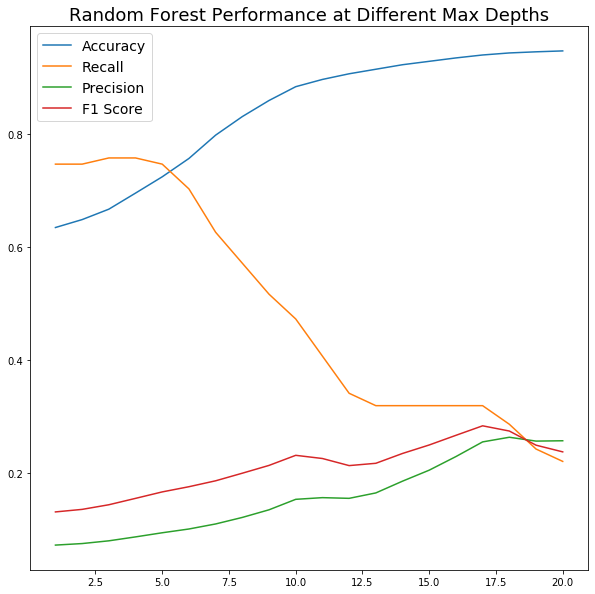

In [73]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(depths, accuracies, label='Accuracy', )
ax.plot(depths, recalls, label='Recall')
ax.plot(depths, precisions, label='Precision')
ax.plot(depths, f1_scores, label='F1 Score')
ax.set_title('Random Forest Performance at Different Max Depths', fontsize = 18)
ax.legend(fontsize = 14)




In [66]:
xgclf = xgb.XGBClassifier(objective = 'reg:logistic')

In [68]:
xgclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [70]:
metric_test(xgclf, X_test, y_test)

accuracy = 0.8007231820008035
recall = 0.6923076923076923
precision = 0.11864406779661017
f1 score = 0.20257234726688103


In [76]:
depthsxg = []
accuraciesxg = []
recallsxg = []
precisionsxg = []
f1_scoresxg = []

for i in range(1, 21):
    xgclf = xgb.XGBClassifier(objective = 'reg:logistic', max_depth = i)
    xgclf.fit(X_train, y_train)
    preds = xgclf.predict(X_test)
    depthsxg.append(i)
    
    accuraciesxg.append(accuracy_score(y_test, preds))
    recallsxg.append(recall_score(y_test, preds))
    precisionsxg.append(precision_score(y_test, preds))
    f1_scoresxg.append(f1_score(y_test, preds))

    print(f'=== Depth of {i}===')
    metric_test(xgclf, X_test, y_test)

=== Depth of 1===
accuracy = 0.6946564885496184
recall = 0.8021978021978022
precision = 0.08957055214723926
f1 score = 0.16114790286975716
=== Depth of 2===
accuracy = 0.7492969063881076
recall = 0.7472527472527473
precision = 0.10164424514200299
f1 score = 0.17894736842105263
=== Depth of 3===
accuracy = 0.8007231820008035
recall = 0.6923076923076923
precision = 0.11864406779661017
f1 score = 0.20257234726688103
=== Depth of 4===
accuracy = 0.8425070309361189
recall = 0.5714285714285714
precision = 0.12839506172839507
f1 score = 0.20967741935483872
=== Depth of 5===
accuracy = 0.8770590598633989
recall = 0.43956043956043955
precision = 0.13559322033898305
f1 score = 0.2072538860103627
=== Depth of 6===
accuracy = 0.8967456809963841
recall = 0.3516483516483517
precision = 0.1391304347826087
f1 score = 0.19937694704049844
=== Depth of 7===
accuracy = 0.9280835676978706
recall = 0.31868131868131866
precision = 0.19863013698630136
f1 score = 0.24472573839662445
=== Depth of 8===
accuracy 

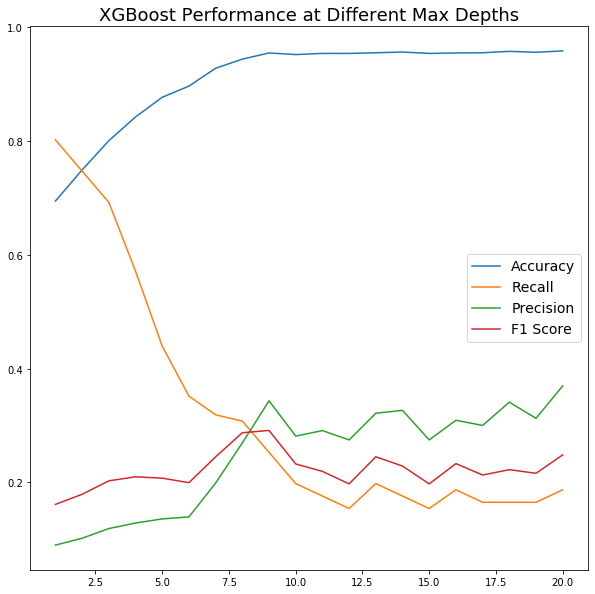

In [77]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(depthsxg, accuraciesxg, label='Accuracy', )
ax.plot(depthsxg, recallsxg, label='Recall')
ax.plot(depthsxg, precisionsxg, label='Precision')
ax.plot(depthsxg, f1_scoresxg, label='F1 Score')
ax.set_title('XGBoost Performance at Different Max Depths', fontsize = 18)
ax.legend(fontsize = 14)



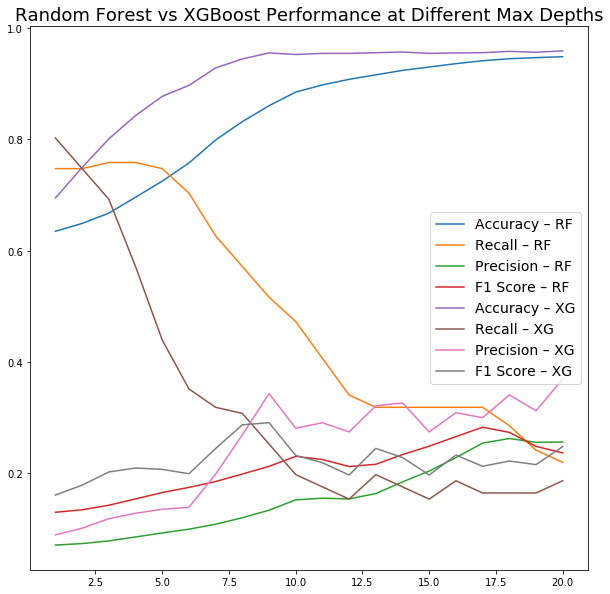

In [79]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(depths, accuracies, label='Accuracy – RF', )
ax.plot(depths, recalls, label='Recall – RF')
ax.plot(depths, precisions, label='Precision – RF')
ax.plot(depths, f1_scores, label='F1 Score – RF')

ax.plot(depthsxg, accuraciesxg, label='Accuracy – XG', )
ax.plot(depthsxg, recallsxg, label='Recall – XG')
ax.plot(depthsxg, precisionsxg, label='Precision – XG')
ax.plot(depthsxg, f1_scoresxg, label='F1 Score – XG')
ax.set_title('Random Forest vs XGBoost Performance at Different Max Depths', fontsize = 18)
ax.legend(fontsize = 14)


In [100]:
df_max = pd.read_pickle('../data/pickles/df_maximus.pkl')

In [106]:
df_max = df_max.dropna()

In [178]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df_max, target = 'pt_attempt', test_size = .25, random_state = 100, VIF_drop = False, scaled = True, minmax = True, resampler = 'upsample', sample_ratio = 1)


TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [179]:
indices

array(['constant', 'year', 'month', 'elected', 'age', 'male',
       'militarycareer', 'tenure_months', 'anticipation', 'ref_ant',
       'leg_ant', 'exec_ant', 'irreg_lead_ant', 'election_now',
       'election_recent', 'leg_recent', 'exec_recent', 'lead_recent',
       'ref_recent', 'direct_recent', 'indirect_recent', 'victory_recent',
       'defeat_recent', 'change_recent', 'nochange_recent', 'delayed',
       'lastelection', 'loss', 'irregular', 'prev_conflict', 'precip',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Age dependency ratio (% of working-age population)',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)',
       'Life expectancy at birth, female (years)',
       'Life expectancy at birth, male (years)',
       'Mortality rate, adult, male (per 1,000 male adults)',
       'Population ages 0-14 (% of total population)',
       'Population grow

In [132]:
xgclf = xgb.XGBClassifier(objective = 'reg:logistic')

In [133]:
xgclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [134]:
metric_test(xgclf, X_test, y_test)

accuracy = 0.8358613217768147
recall = 0.5238095238095238
precision = 0.14332247557003258
f1 score = 0.22506393861892585


In [111]:
metric_test(xgclf, X_test, y_test)

accuracy = 0.8001083423618635
recall = 0.6785714285714286
precision = 0.14285714285714285
f1 score = 0.2360248447204969


In [112]:
clf = RandomForestClassifier( n_estimators = 1000, max_depth = 5)

In [113]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [114]:
metric_test(clf, X_test, y_test)

accuracy = 0.7161430119176598
recall = 0.7619047619047619
precision = 0.11267605633802817
f1 score = 0.19631901840490798


In [163]:
df_max.columns

Index(['year', 'month', 'elected', 'age', 'male', 'militarycareer',
       'tenure_months', 'anticipation', 'ref_ant', 'leg_ant', 'exec_ant',
       'irreg_lead_ant', 'election_now', 'election_recent', 'leg_recent',
       'exec_recent', 'lead_recent', 'ref_recent', 'direct_recent',
       'indirect_recent', 'victory_recent', 'defeat_recent', 'change_recent',
       'nochange_recent', 'delayed', 'lastelection', 'loss', 'irregular',
       'prev_conflict', 'precip',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Age dependency ratio (% of working-age population)',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)',
       'Life expectancy at birth, female (years)',
       'Life expectancy at birth, male (years)',
       'Mortality rate, adult, male (per 1,000 male adults)',
       'Population ages 0-14 (% of total population)',
       'Population growth (annual %

In [164]:
features_names_max = ['year', 'month', 'elected', 'age', 'male', 'militarycareer',
       'tenure_months', 'anticipation', 'ref_ant', 'leg_ant', 'exec_ant',
       'irreg_lead_ant', 'election_now', 'election_recent', 'leg_recent',
       'exec_recent', 'lead_recent', 'ref_recent', 'direct_recent',
       'indirect_recent', 'victory_recent', 'defeat_recent', 'change_recent',
       'nochange_recent', 'delayed', 'lastelection', 'loss', 'irregular',
       'prev_conflict', 'precip',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Age dependency ratio (% of working-age population)',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)',
       'Life expectancy at birth, female (years)',
       'Life expectancy at birth, male (years)',
       'Mortality rate, adult, male (per 1,000 male adults)',
       'Population ages 0-14 (% of total population)',
       'Population growth (annual %)',
       'Rural population (% of total population)',
       'Urban population growth (annual %)', 'imports', 'exports', 'milex',
       'milper', 'irst', 'pec', 'upop', 'cinc', 'Dominant Party',
       'Foreign/Occupied', 'Indirect Military', 'Military',
       'Military-Personal', 'Monarchy', 'Oligarchy', 'Party-Military',
       'Party-Personal', 'Party-Personal-Military Hybrid',
       'Personal Dictatorship', 'Presidential Democracy',
       'Provisional - Civilian', 'Provisional - Military', 'Warlordism']

In [161]:
clf.feature_importances_

array([2.47128607e-02, 0.00000000e+00, 2.38380171e-03, 7.70189498e-03,
       3.80408314e-04, 4.99141864e-03, 3.37229355e-02, 8.30970872e-04,
       1.24468612e-03, 1.22972884e-04, 9.58505885e-04, 1.03362668e-03,
       8.62019611e-06, 9.86140328e-04, 1.93394944e-07, 2.58158571e-04,
       6.02988495e-04, 4.34571211e-04, 5.51265883e-04, 1.24747305e-05,
       1.24797806e-04, 3.39144292e-04, 2.17549230e-04, 2.16426626e-04,
       3.60200850e-04, 1.12478451e-02, 1.75506376e-02, 4.74528666e-02,
       4.17525745e-03, 6.73342188e-03, 4.02008097e-02, 4.94743461e-02,
       9.41705378e-02, 3.31527853e-02, 9.18507088e-02, 7.36368608e-02,
       7.24032283e-02, 4.12557106e-02, 4.83341589e-02, 2.19148292e-02,
       2.28679645e-02, 3.61231181e-02, 4.45687954e-02, 2.47514310e-02,
       2.05307192e-02, 1.44521948e-02, 1.91028262e-02, 1.76518792e-02,
       1.67916103e-02, 1.92393179e-02, 1.23706942e-02, 2.54184291e-04,
       3.65050578e-03, 5.57773908e-03, 1.64024282e-03, 7.53021005e-04,
      

In [167]:
len(features_names_max)

65

In [176]:
clf.feature_importances_[3]

0.007701894977942559

In [177]:
for idx, feature in enumerate(features_names_max):
    print(f'{feature}: {clf.feature_importances_[idx]}')

year: 0.02471286074439627
month: 0.0
elected: 0.0023838017147233253
age: 0.007701894977942559
male: 0.0003804083138038067
militarycareer: 0.004991418644001189
tenure_months: 0.03372293545157762
anticipation: 0.0008309708723796264
ref_ant: 0.0012446861194596317
leg_ant: 0.0001229728837191305
exec_ant: 0.000958505885027062
irreg_lead_ant: 0.001033626677696916
election_now: 8.620196107337408e-06
election_recent: 0.0009861403281451499
leg_recent: 1.9339494441493876e-07
exec_recent: 0.0002581585705758732
lead_recent: 0.0006029884953356381
ref_recent: 0.0004345712111487817
direct_recent: 0.0005512658825245688
indirect_recent: 1.2474730508732176e-05
victory_recent: 0.00012479780612793882
defeat_recent: 0.0003391442920407496
change_recent: 0.00021754923008292294
nochange_recent: 0.00021642662597365714
delayed: 0.00036020084980631194
lastelection: 0.011247845073739417
loss: 0.0175506375926013
irregular: 0.04745286660422573
prev_conflict: 0.0041752574509499275
precip: 0.006733421876839129
Adoles

In [159]:
metric_test(clf, X_test, y_test)

accuracy = 0.7161430119176598
recall = 0.7619047619047619
precision = 0.11267605633802817
f1 score = 0.19631901840490798


In [160]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [145]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df_max, target = 'pt_attempt', test_size = .25, random_state = 100, VIF_drop = False, scaled = False, minmax = False, resampler = 'upsample', sample_ratio = 1)


/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [146]:
xgclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [155]:
xgclf3 = xgb.XGBClassifier(objective = 'reg:logistic',  learning_rate=0.1, max_depth=3, n_estimators=100)

In [157]:
xgclf3.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
metric_test(xgclf3, X_test, y_test)

In [158]:
metric_test(xgclf3, X_test, y_test)

accuracy = 0.9458288190682557
recall = 0.16666666666666666
precision = 0.3181818181818182
f1 score = 0.21874999999999997


In [147]:
metric_test(xgclf, X_test, y_test)

accuracy = 0.8001083423618635
recall = 0.6785714285714286
precision = 0.14285714285714285
f1 score = 0.2360248447204969


In [ ]:
accuracy = 0.7593411008437123
recall = 0.7032967032967034
precision = 0.10062893081761007
f1 score = 0.17606602475928473

In [152]:
probs = xgclf.predict_proba(X_test)

In [154]:
probs[:,1].argsort()

array([699, 460, 125, ..., 714, 753,  72])

In [180]:
from sklearn.pipeline import Pipeline

In [186]:
y = df_max['pt_attempt']

In [187]:
X = df_max.drop(['pt_attempt','pt_suc'], axis = 1)

In [ ]:
def upsampler(X_train, y_train, target = 'pt_attempt'):
    '''
    Args: X_train and y_train
    Optional: what is the target
    Returns: y_train, and X_train with the target rows sampled with replacement to equal 
    the number of non-target rows (makes X_train much bigger)
    '''
    y_train = pd.Series(y_train)
    
    X = pd.concat([X_train, y_train], axis=1) 
    no_coup = X[X[target]==0]
    coup = X[X[target]==1]
    coups_upsampled = resample(coup,
                          replace=True, # sample with replacement
                          n_samples=len(no_coup), # match number in majority class
                          random_state=29)
    upsampled = pd.concat([no_coup, coups_upsampled])
    y_up = upsampled[target]
    X_up = upsampled.drop(target, axis = 1)
    return X_up, y_up

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .25, random_state= 40, stratify = y)

In [191]:
X_up, y_up = upsampler(X_train, y_train)

In [181]:
pipe = Pipeline([('scaler', StandardScaler()), ('random forest', RandomForestClassifier( n_estimators = 1000, max_depth = 5))])

In [192]:
pipe.fit(X_up, y_up)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('random forest',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=5,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [193]:
metric_test(pipe, X_test, y_test)

accuracy = 0.718851570964247
recall = 0.7023809523809523
precision = 0.10669077757685352
f1 score = 0.18524332810047098


In [195]:
xgpipe = Pipeline([('scaler', StandardScaler()),('xgboost', xgb.XGBClassifier(objective = 'reg:logistic',  learning_rate=0.1, max_depth=3, n_estimators=100))])

In [196]:
xgpipe.fit(X_up, y_up)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgboost',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='reg:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [197]:
metric_test(xgpipe, X_test, y_test)

accuracy = 0.8066088840736728
recall = 0.6071428571428571
precision = 0.136
f1 score = 0.22222222222222224


In [1]:
clf = RandomForestClassifier(max_depth=5, n_estimators=1000)

NameError: name 'RandomForestClassifier' is not defined